In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math

"""
Values from "Generalization second order macroscopic models via relative velocity of the
shockwave propagation" (p.16)
"""
r1 = 0.023
r2 = 0.036
alpha = [52.5, -1026.9]
beta = [0.46, 22.3, -585.5]
rmax = 0.145
vmax = 50
cstar = 4.57  
cmin = 0.001
min_r = 0.0002
vmin = 2
e = 0.001
M = 20
X = 1000
dx = X / (M-1)


def get_c(new_r):
  """
  Finding c(r) depending on r 
  if r is out of scope, return minimal c
  """
  if 0 <= new_r < r1: 
    new_c = alpha[1]* new_r
  elif r1 <= new_r < r2:
    new_c = beta[2]* new_r - (beta[0]/ new_r)
  elif r2 <= new_r <= rmax: 
    new_c = - (cstar * rmax) / new_r
  else: 
    new_c = cmin
  return new_c if math.fabs(new_c) > cmin else cmin

In [0]:
class VehicleGroup:
    """
    Class for storage of history for velocity, c(r), r and q of the road
    """
    def __init__(self, r, name=None, v=15):
      self.name = name
      self.v = [v]
      self.c = [get_c(r)]
      self.r = [r]
      self.q = [r*v]

In [0]:
def check_r_v(r_, v_):
  """
  Checking if r and velocity is in scope
  if r is small, set v to small value
  """
  if r_ <= min_r or np.isnan(r_):
    return min_r + e, vmin + 1
  elif r_ >= rmax:
    return rmax - e, v_
  if v_ <= vmin:
    return r_, vmin + 1
  elif v_ >= vmax:
    return r_, vmax - 1
  return r_, v_


def check_c(c_):
  """
  Checking if c is in scope 
  """
  if abs(c_) < cmin: 
      return cmin
  if abs(c_) > vmax:
      return c_ * 0.7
  return c_


def get_A(flow, flow2=None):
  """
  Get Jacobian matrix (if intermediate values is needed, firstly find them by averaging)
  flow, flow2: data from road, class VehicleGroup
  """
  A = np.zeros((2,2))
  if flow2:
      v_ = (flow.v[-1] + flow2.v[-1]) / 2
      r_ = (flow.r[-1] + flow2.r[-1]) / 2
      c_ = get_c(r_)
  else:
    v_ = flow.v[-1]
    r_ = flow.r[-1]
    c_ = flow.c[-1]
  
  A[0,0] = v_
  A[0,1] = r_
  A[1,1] = v_ + c_

  return A

def get_lam(flow, flow2=None):
  """
  Get Jacobian matrix (if intermediate values is needed, firstly find them by averaging)
  But with absolute values of lambda component
  flow, flow2: data from road, class VehicleGroup
  """

  if flow2:
      v_ = (flow.v[-1] + flow2.v[-1]) / 2
      r_ = (flow.r[-1] + flow2.r[-1]) / 2
      c_ = get_c(r_)
  else:
    v_ = flow.v[-1]
    r_ = flow.r[-1]
    c_ = flow.c[-1]
  
  A1 = np.array([[r_/c_, r_/c_],[0, 1]]) # omega -1
  A2 = np.array([[v_,0],[0, abs(c_+v_)]])  # lambda
  A3 = np.array([[c_/r_, -1],[0, 1]]) # omega
  A = np.dot(A1, A2)
  return np.dot(A, A3)

def get_W(flow):
  """
  Get W matrix for updating the road
  flow: data from road, class VehicleGroup
  """
  return  np.array([flow.r[-1], flow.v[-1]]).T

In [0]:
class Road:
  """
  Macroscopic model of the road
  X - len of the road
  M - number of checkpoints (detectors) on the road
  """
  def __init__(self, M, r, v, X=None):
    """
    Set r, v for each part of the road. 
    Find dx, dt while initializing road.
    Create M checkpoints (detectors) for storage of the data 
        - dictionary where key is a number of checkpoint on the road 
                       and a value is VehicleGroup 
    """
    l1 = v
    l2 = get_c(r) + v
    self.X = 1000 if not X else X
    self.M = M
    self.dx = self.X / (M-1)
    self.dt = min([self.dx / math.fabs(l2), self.dx / l1]) 
    
    self.checkpoints = {}
    for x in range(0, M):
      flow = VehicleGroup(r, v=v)
      self.checkpoints[x] = flow

  def update_dt(self):
    """
    update dt after each iteration by finding minimum value 
    """
    l1 = [math.fabs(self.dx/ self.checkpoints[i].v[-1]) for i in self.checkpoints]
    l2 = [math.fabs(self.dx / (get_c(self.checkpoints[i].r[-1]) + self.checkpoints[i].v[-1])) for i in self.checkpoints]
    return min(l1+l2)
  
  def append_val(self, point, r_, v_):
    """
    Updating road checkpoints (detectors) on the road 
        with new value for r and velocity
    """
    self.checkpoints[point].r.append(r_) 
    self.checkpoints[point].v.append(v_)
    self.checkpoints[point].q.append(r_*v_)
    c_ = check_c(get_c(r))
    self.checkpoints[point].c.append(c_)


  def update(self, r, v):
    """
    Iteration step.
    Updating through computing W matrix. For that we need G matrix that use intermediate values.
        For that we find intermediate A (Jacobian) matrices for all points
    Checking obtained velocity and r values, store new values.
    Updating dt. 
    """

    # Intermediate Matrices A for previous point 
    matr_a0 = [get_A(self.checkpoints[x], self.checkpoints[x-1]) for x in range(1, self.M)]
    matr_a01 = [get_lam(self.checkpoints[x], self.checkpoints[x-1]) for x in range(1, self.M)]

    # Intermediate Matrices A for next point 
    matr_a2 = [get_A(self.checkpoints[x], self.checkpoints[x+1]) for x in range(0, self.M-1)]
    matr_a21 = [get_lam(self.checkpoints[x], self.checkpoints[x+1]) for x in range(0, self.M-1)]
    
    # W matrices  
    matr_w = [get_W(self.checkpoints[x]) for x in range(0, self.M)] 

    # border point updating with input values
    r_, v_ = check_r_v(r, v)
    self.append_val(0, r_, v_)

    # inner points updating by formulas
    for x in range(1, self.M-1):

      matr_g2 = 0.5 * (np.dot(matr_a2[x], (matr_w[x] + matr_w[x+1]) ) + \
         np.dot(matr_a21[x], (matr_w[x] - matr_w[x+1]) ))

      matr_g0 = 0.5 * (np.dot(matr_a0[x-1], (matr_w[x] + matr_w[x-1])) - \
         np.dot(matr_a01[x -1], (matr_w[x] - matr_w[x-1])))

      matr_w1 = matr_w[x] - (self.dt/self.dx) * (matr_g2 - matr_g0)
      matr_w1.T
      
      r_, v_ = check_r_v(matr_w1[0], matr_w1[1])
      self.append_val(x, r_, v_)

    # border point updating by copying previous step values 
    self.append_val(M-1, r_, v_)
    
    # update dt 
    dt_ = self.update_dt()
    self.dt = dt_ if dt_ > 0 else self.dt

## One Road 

In [0]:
r = 0.02
v = 40
road = Road(20, r, v, X=10000)

In [0]:
total_time = 1000
spent_time = 0
times = [0]
while spent_time < total_time:
  spent_time += road.dt
  times.append(spent_time)
  road.update(r,v)
  # increase r by small value
  r *= 1.0001

## Plots

*    Dependencies of r and velocity at the end of simulation (or at the given iteration step) on all points. 

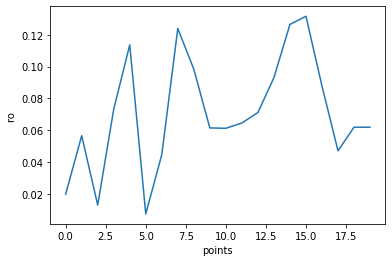

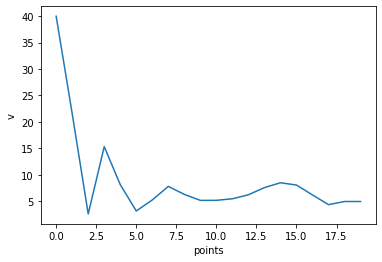

In [0]:
iter_ = -1
r_ = [road.checkpoints[x].r[iter_] for x in road.checkpoints]
v_ = [road.checkpoints[x].v[iter_] for x in road.checkpoints]

x = [x for x in range(0,20)]

plt.plot(x, r_)
plt.xlabel('points')
plt.ylabel('ro ')
plt.show()
plt.plot(x, v_)
plt.xlabel('points')
plt.ylabel('v')
plt.show()

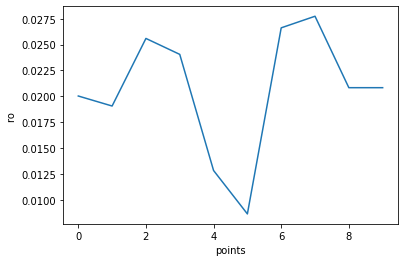

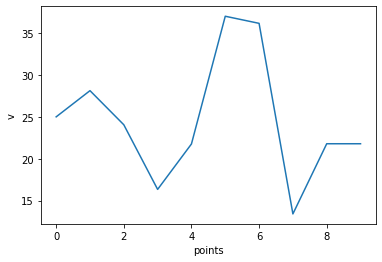

In [0]:
iter_ = 15
r_ = [road.checkpoints[x].r[iter_] for x in road.checkpoints]
# r1_ = [road.checkpoints[x].r[iter_+1] for x in road.checkpoints]
v_ = [road.checkpoints[x].v[iter_] for x in road.checkpoints]

x = [x for x in range(0,10)]

plt.plot(x, r_)
# plt.plot(x, r1_)
plt.xlabel('points')
plt.ylabel('ro ')
plt.show()
plt.plot(x, v_)
plt.xlabel('points')
plt.ylabel('v')
plt.show()

*    Dependencies of r and velocity at the given point from time



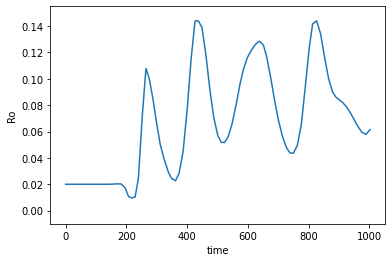

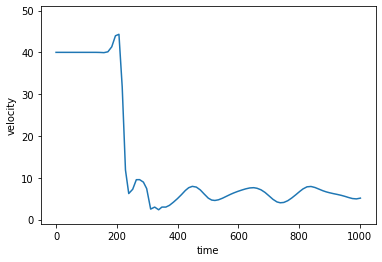

In [0]:
point = 9
plt.plot(times, road.checkpoints[point].r)
plt.ylim(-0.01, rmax + 0.01)
plt.xlabel('time')
plt.ylabel('Ro')
plt.show()

plt.plot(times, road.checkpoints[point].v)
plt.ylim(-1, vmax+1)
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()

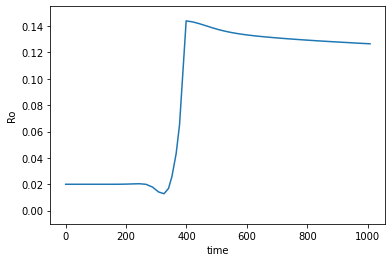

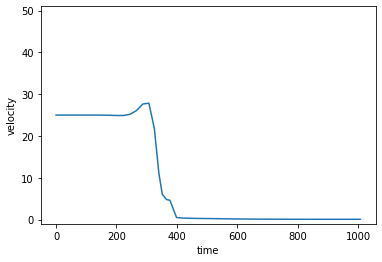

In [0]:
point = 4
plt.plot(times, road.checkpoints[point].r)
plt.ylim(-0.01, rmax + 0.01)
plt.xlabel('time')
plt.ylabel('Ro')
plt.show()

plt.plot(times, road.checkpoints[point].v)
plt.ylim(-1, vmax+1)
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()

We can see that if r increases, velocity go down and vice versa.

*      Dependencies of velocity and c from r

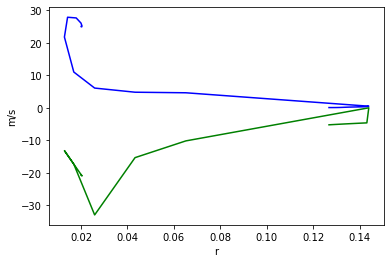

In [0]:
plt.plot(road.checkpoints[point].r[1:-1], road.checkpoints[point].v[1:-1], 'b', label='v(p)')
plt.xlabel('r')
plt.ylabel('m/s')

plt.plot(road.checkpoints[point].r[1:-1], road.checkpoints[point].c[1:-1], 'g', label='c(p)')
plt.show()

## T-form intersection (1 method)



![alt text](https://drive.google.com/uc?id=11DVlM5MNltH1RmyWUxKy-oFGMn4ytdPm)

In [0]:
r = 0.015
r4 = 0.01
v = 30
v4 = 30

C = 0.8  #part of the flow 1 that will turn to 3rd road 

total_time = 3000
M = 20
X = 10000

road3 = Road(M, r*(C-1), v, X=X)
road1 = Road(M, r, v,X=X)
road4 = Road(M, r4 , v,X=X)
road2 = Road(M, r4 + r*C, v,X=X)

In [0]:
spent_time = 0
dt = min([fl.dt for fl in [road1, road2, road3, road4]])
times = [0]

while spent_time < total_time:
  spent_time += dt
  times.append(spent_time)
  
  # first and fourth road - beginning the same
  road1.update(r, v)
  road4.update(r4,v)

  # second road  - merge first and fourth
  r2_ = C*road1.checkpoints[M-1].r[-1] + road4.checkpoints[M-1].r[-1]
  v2 = (road1.checkpoints[M-1].v[-1] + road4.checkpoints[M-1].v[-1]) / 2
  # print(r2)
  road2.update(r2_,v2)

  # third - split first road
  r3 = (1-C) * road1.checkpoints[M-1].r[-1] 
  v3 = road1.checkpoints[M-1].v[-1] 
  road3.update(r3,v3)

  dt = min([fl.dt for fl in [road1, road2, road3, road4]])

  # # change r for border points  
  r *= 1.0001
  
  # Q2=Q1+Q4-Q3 
   
  q2 = road2.checkpoints[0].q[-1]
  q3 = road3.checkpoints[0].q[-1]

  q1 = road1.checkpoints[M-1].q[-1]
  q4 = road4.checkpoints[M-1].q[-1]


  assert abs(q2 - (q1 + q4 - q3)) <= 0.001,  print(q2, (q1 + q4 - q3), len(times))


For the begining of the second road dependecies of r,q and velocity from time

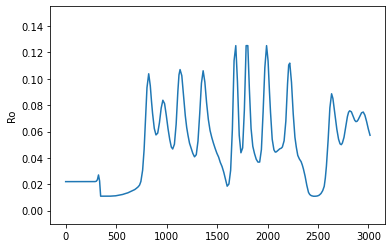

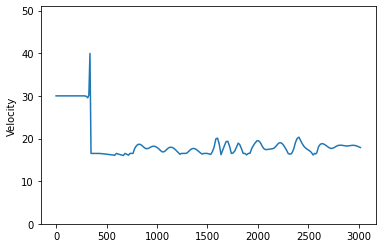

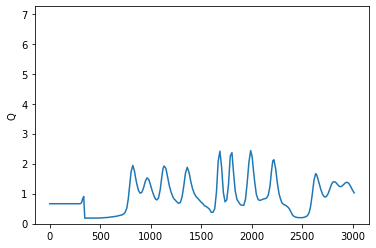

In [0]:
p = 0
plt.plot(times, road2.checkpoints[p].r)
plt.ylim(-0.01, rmax+.01)
plt.ylabel("Ro")
plt.show()

plt.plot(times, road2.checkpoints[p].v)
plt.ylim(-0.01, vmax+1)
plt.ylabel("Velocity")
plt.show()

Q = [road2.checkpoints[p].r[i] * road2.checkpoints[p].v[i] for i in range(len(road2.checkpoints[p].v))]

plt.plot(times, Q)
plt.ylim(-0.01, rmax*vmax)
plt.ylabel("Q")
plt.show()

## T-form intersection (2 method)

![alt text](https://drive.google.com/uc?id=1kg7tDiwRg4n6DCepzSLAabbM9ixg7WZc)

In [0]:
class Edge:
  """
  Computing intermediate values for edges of sectors of the intersection
  """
  def __init__(self, r1, r2, v1, v2):
    """
    r1, v1 - values at one side of the edge
    r2, v2 - the other side
    """
    self.r1 = r1
    self.r2 = r2
    self.v1 = v1
    self.v2 = v2 
    self.q_r = self.v2 + get_c(self.r2)
    self.Q = 0.5*(self.r1*self.v1 + self.r2*self.v2 + abs(self.q_r)*(self.r1-self.r2)) 
    self.V = 0.5*(self.v1 + self.v2 + math.copysign((self.v1 - self.v2), self.q_r)) 
    self.R = self.Q / self.V

In [0]:
def sector_dt(road):
    l1 = [abs(sector_dx/ road.checkpoints[i].v[-1]) for i in road.checkpoints]
    l2 = [abs(sector_dx / (get_c(road.checkpoints[i].r[-1]) + road.checkpoints[i].v[-1])) for i in road.checkpoints]
    return min(l1+l2)

In [0]:
r1_ = 0.025
r5_ = 0.015
v1_ = 30
v5_ = 25

total_time = 1000
M = 20
X = 5000

road1 = Road(M, r1_, v1_, X=X)
road4 = Road(M, r1_ , v1_, X=X)
road5 = Road(M, r5_ , v5_, X=X)
road6 = Road(M, r5_ , v5_, X=X)

sector_dx = road1.dx / 10
sector_dy = road1.dx / 10

road_dt = min([sector_dt(fl) for fl in [road1, road4, road5, road6]])

# initialize sectors of intersection with some values 
R2 = r
R3 = r
V2X = v
V2Y = vmin
V3X = v

# find values at the edges between sectors
e12 = Edge(road1.checkpoints[road1.M - 1].r[-1], R2,
            road1.checkpoints[road1.M - 1].v[-1], V2X)
e23 = Edge(R2 , R3, V2X, V3X)
# Vy = 0 for edge 2,5
e25 = Edge(R2, road5.checkpoints[0].r[-1], 
            V2Y, road5.checkpoints[0].v[-1])
# Vx = 0 for edge 6,3
e63 = Edge(road6.checkpoints[road1.M - 1].r[-1], R3,
            road6.checkpoints[road1.M - 1].v[-1], vmin)

e34 = Edge(R3, road4.checkpoints[0].r[-1],
            V3X, road4.checkpoints[0].v[-1])

In [0]:
spent_time = 0
times = [0]
Q_alpha = [q_alpha] # keep track what part of the flow take turn to the fifth road

while spent_time < total_time:
  spent_time += road_dt
  times.append(spent_time)

  # update sectors  
  q_alpha = road5.checkpoints[0].q[-1] / road1.checkpoints[road1.M-1].q[-1]
  Q_alpha.append(q_alpha)

  R2_ = R2 - road_dt * ((e23.Q - e12.Q*q_alpha - e12.Q) / sector_dx + (e25.Q + q_alpha*e12.Q) / sector_dy)
  R3_ = R3 - road_dt * ( (e34.Q + e63.Q - e23.Q) / sector_dx)   # e23.Q
  V2X_ = V2X - road_dt * ((V2X + get_c(R2))*((e23.V - e12.V) /sector_dx))
  V2Y_ =  V2Y - road_dt * ((V2Y + get_c(R2))*(e25.V /sector_dy)) 
  V3X_ = V3X - road_dt * ((V3X + get_c(R3))*( (e34.V - e23.V) /sector_dx))

  R2 = R2_
  R3 = R3_
  V2X = V2X_
  V2Y = V2Y_
  V3X = V3X_

  # update edges
  e12 = Edge(road1.checkpoints[road1.M - 1].r[-1], R2,
             road1.checkpoints[road1.M - 1].v[-1], V2X)
  e23 = Edge(R2 , R3, V2X, V3X)

  e25 = Edge(R2, road5.checkpoints[0].r[-1], 
             V2Y, road5.checkpoints[0].v[-1])
  # Vx = 0 for edge 6,3
  e63 = Edge(road6.checkpoints[road1.M - 1].r[-1], R3,
             road6.checkpoints[road1.M - 1].v[-1], vmin)
  
  e34 = Edge(R3, road4.checkpoints[0].r[-1],
             V3X, road4.checkpoints[0].v[-1])

  r5 = e25.R
  v5 = e25.V
  r4 = e34.R
  v4 = e34.V
  
  road5.update(r5,v5) 
  road4.update(r4,v4) 
  # first and fourth road - beginning the same
  road1.update(r, v)
  road6.update(r,v)

   #  Q4=Q1+Q6-Q5 
  assert abs(road4.checkpoints[0].r[-1]  - (road1.checkpoints[M-1].r[-1] + road6.checkpoints[M-1].r[-1] - road5.checkpoints[0].r[-1])) <= 0.001,\
     print(len(times))

    
  road_dt = min([sector_dt(fl) for fl in [road1, road4, road5, road6]])

Dependencies of r and velocity from time for begining of fifth road

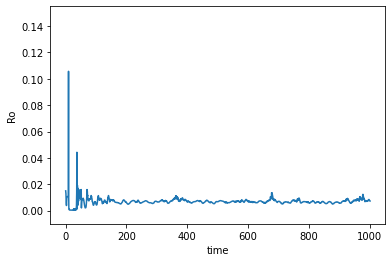

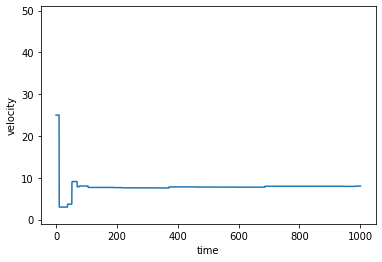

In [0]:
point = 0
plt.plot(times, road5.checkpoints[point].r)
plt.ylim(-0.01, rmax + 0.01)
plt.xlabel('time')
plt.ylabel('Ro')
plt.show()

plt.plot(times, road5.checkpoints[point].v)
plt.ylim(-1, vmax+1)
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()


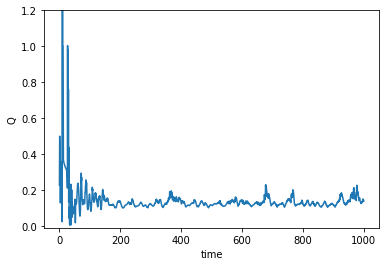

0.13799714140014782

In [0]:
plt.plot(times, Q_alpha)  # Q alpha - what part of flow 1 goes to 5th road 
plt.ylim(-0.01, 1.2)
plt.xlabel('time')
plt.ylabel('Q')
plt.show()
Q_alpha[-1]